In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import binned_statistic # for binning pdays
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_csv('bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [155]:
df.info() 

# there are no null entries - this is great

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [156]:
df.describe()
# many cols are categorical - run this again later since some col don't make sense

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [157]:
df = df.rename(columns = {'y':'deposit'}) # change y col to deposit

# Data Wrangling

## Age

In [158]:
unique_ages = df.age.unique()
# sorted(unique_ages)

unique_ages

array([58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 57, 51, 45, 60, 56, 32,
       25, 40, 39, 52, 46, 36, 49, 59, 37, 50, 54, 55, 48, 24, 38, 31, 30,
       27, 34, 23, 26, 61, 22, 21, 20, 66, 62, 83, 75, 67, 70, 65, 68, 64,
       69, 72, 71, 19, 76, 85, 63, 90, 82, 73, 74, 78, 80, 94, 79, 77, 86,
       95, 81, 18, 89, 84, 87, 92, 93, 88])

Viewing the unique age outputs above.  The age column ranges from 18 to 95 years, which is reasonable.  All of the ages are 2 digit integers so this column is clean.

In [159]:
df.age.mean()

40.93621021432837

The median age is 41 years old.

In [160]:
med_age = df.groupby(['job'])['age'].median()
med_age.sort_values(ascending=False, inplace=True)
med_age # sorting jobs by median age

job
retired          59
unknown          47
housemaid        47
entrepreneur     41
unemployed       40
self-employed    39
blue-collar      39
management       38
admin.           38
technician       37
services         37
student          26
Name: age, dtype: int64

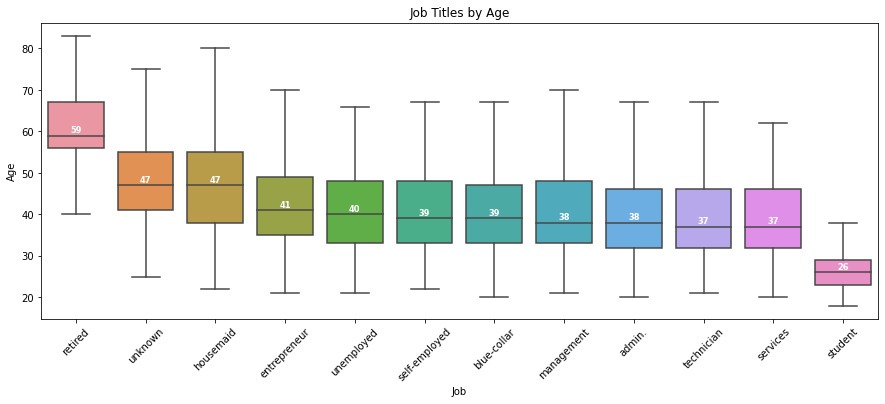

In [161]:
fig = plt.figure(figsize=(15,12))

_ = plt.subplot(2,1,1)
box_plot = sns.boxplot('job','age',data=df,
                       showfliers=False,order=['retired','unknown','housemaid',
                                              'entrepreneur','unemployed','self-employed',
                                              'blue-collar','management','admin.','technician',
                                              'services','student']) #outliers removed
_ = plt.xlabel('Job')
_ = plt.ylabel('Age')
_ = plt.xticks(rotation=45)
_ = plt.title('Job Titles by Age')

vertical_offset = df['age'].median() * 0.02 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,med_age[xtick] + vertical_offset,med_age[xtick], 
            horizontalalignment='center',size='small',color='w',weight='semibold')

## Job

In [162]:
len(df.job.unique())

12

In [163]:
df.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

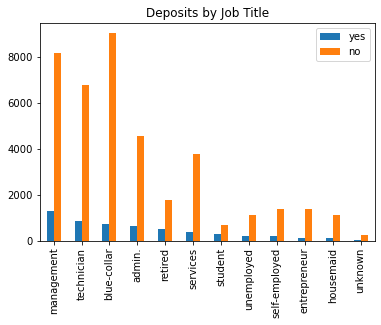

In [164]:
job_df = pd.DataFrame()

job_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
job_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

_ = job_df.plot.bar(title = 'Deposits by Job Title')

In [165]:
job_age = df.groupby(['job'], as_index=False)['age'].median().sort_values('age',ascending=False) # job df grouped by median age

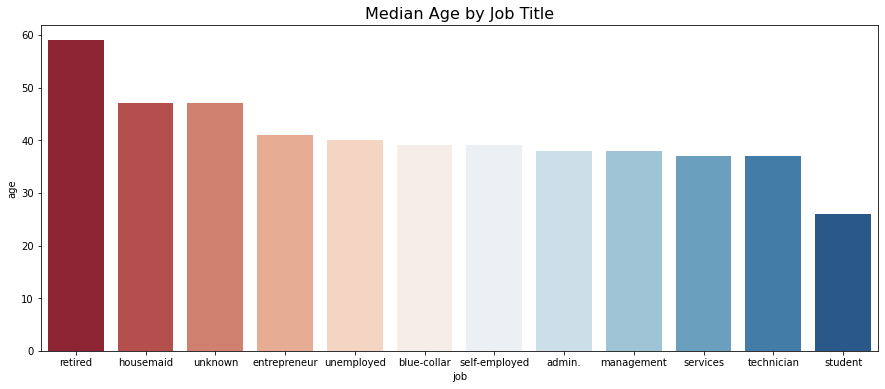

In [166]:
fig = plt.figure(figsize=(15,6))

_ = sns.barplot(x="job", y="age", data=job_age,
            label="Total", palette="RdBu")

_ = plt.title('Median Age by Job Title', fontsize=16)

## Marital

In [167]:
df.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

There are 3 unique marital statuses and all are categorical values.

In [168]:
# marital status percentages:

df['marital'].value_counts(normalize=True) * 100

married     60.193316
single      28.289576
divorced    11.517109
Name: marital, dtype: float64

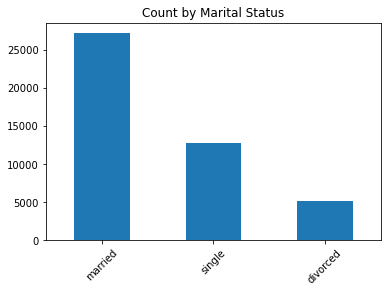

In [169]:
_ = df.marital.value_counts().plot.bar()
_ = plt.xticks(rotation=45)
_ = plt.title('Count by Marital Status')

Married accounts for the majority, then single and divorced last.

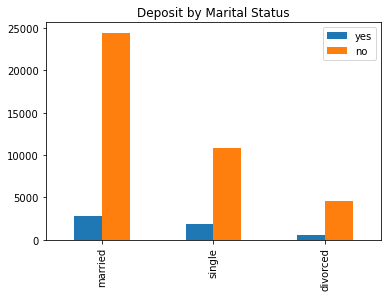

In [170]:
job_df = pd.DataFrame()

job_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
job_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

_ = job_df.plot.bar(title = 'Deposit by Marital Status')

## Education

In [171]:
df.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

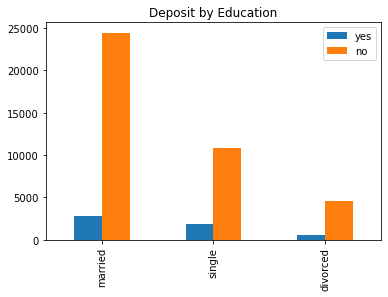

In [172]:
education_df = pd.DataFrame()

education_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
education_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

_ = job_df.plot.bar(title = 'Deposit by Education')

## Default

This column shows whether the person has credit in default

In [173]:
df.default.value_counts()

no     44396
yes      815
Name: default, dtype: int64

In [174]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


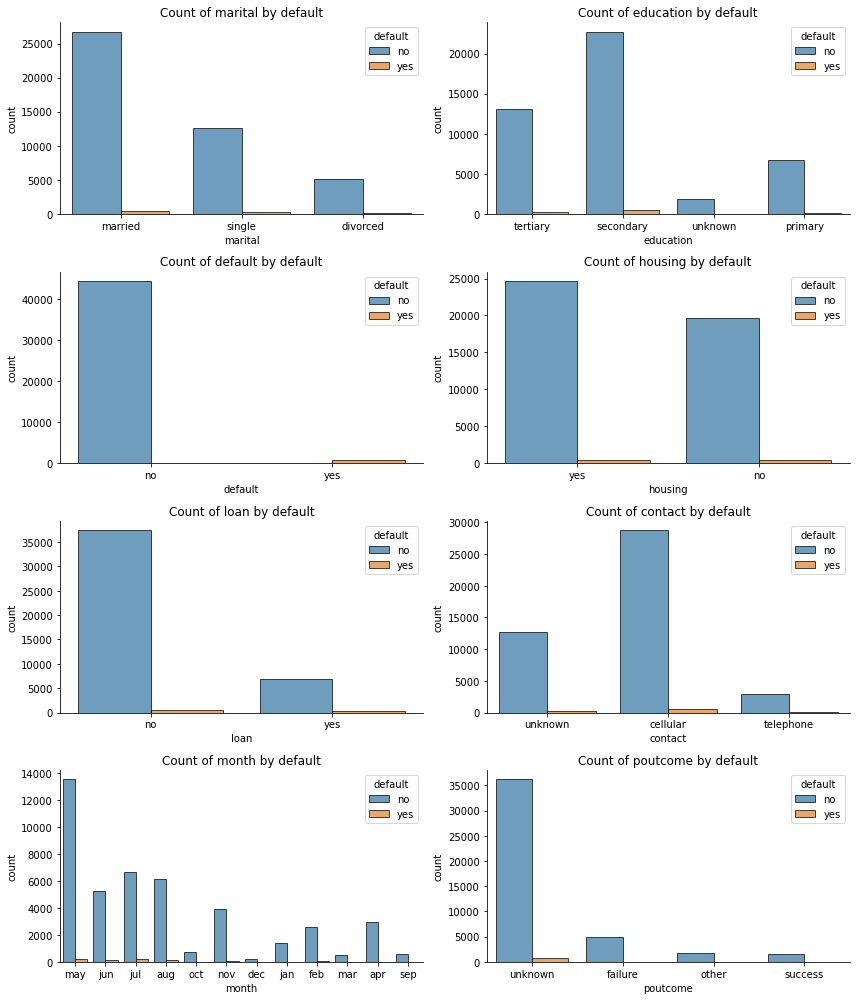

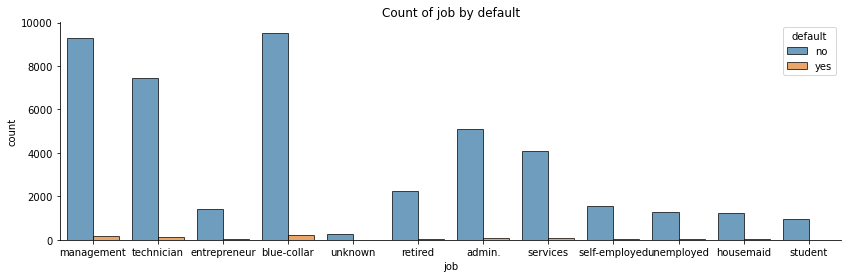

In [175]:
plt.figure(figsize=[12,14])

default_categ = ['marital','education','default','housing','loan','contact','month','poutcome']
n=1

for x in default_categ:
    plt.subplot(4,2,n)
    sns.countplot(x=x, hue='default', edgecolor="black", alpha=0.7, data=df)
    sns.despine()
    plt.title("Count of {} by default".format(x))
    n=n+1
plt.tight_layout()
plt.show()

plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='default',edgecolor="black", alpha=0.7, data=df)
sns.despine()
plt.title("Count of job by default")
plt.show()

## Balance

In [176]:
len(df.balance.unique())

7168

In [177]:
df.balance.unique()

array([ 2143,    29,     2, ...,  8205, 14204, 16353])

In [178]:
med_balance = df.groupby('job')['balance'].median()
med_balance.sort_values(ascending=False, inplace=True)
med_balance # sorting jobs by median balance

job
retired          787.0
unknown          677.0
management       572.0
unemployed       529.0
self-employed    526.0
student          502.0
technician       421.0
housemaid        406.0
admin.           396.0
blue-collar      388.0
entrepreneur     352.0
services         339.5
Name: balance, dtype: float64

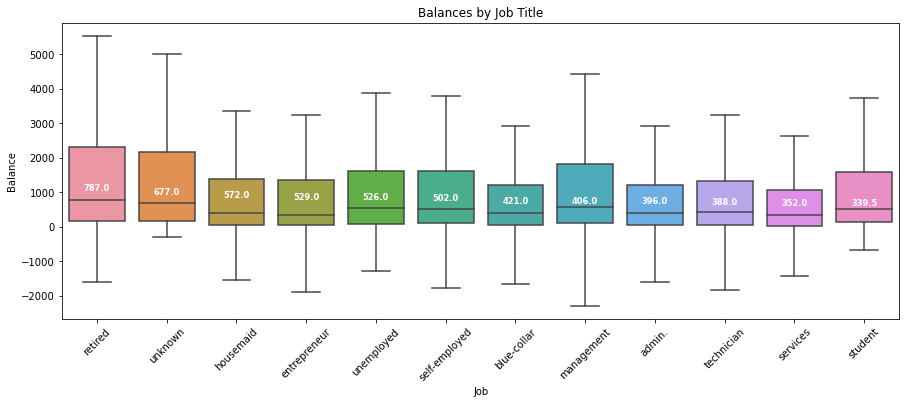

In [179]:
fig = plt.figure(figsize=(15,12))

_ = plt.subplot(2,1,1)
box_plot = sns.boxplot('job','balance',data=df,
                       showfliers=False,order=['retired','unknown','housemaid',
                                              'entrepreneur','unemployed','self-employed',
                                              'blue-collar','management','admin.','technician',
                                              'services','student']) #outliers removed
_ = plt.xlabel('Job')
_ = plt.ylabel('Balance')
_ = plt.xticks(rotation=45)
_ = plt.title('Balances by Job Title')

vertical_offset = df['balance'].median() * 0.6 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,med_balance[xtick] + vertical_offset,med_balance[xtick], 
            horizontalalignment='center',size='small',color='w',weight='semibold')

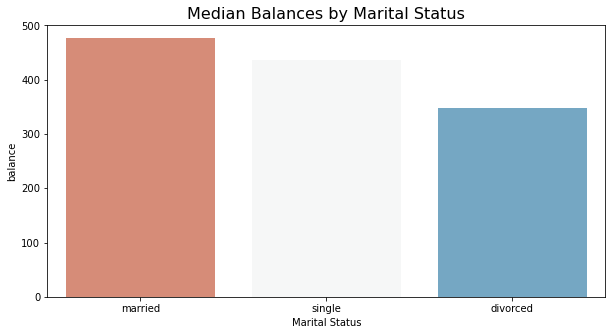

In [180]:
marital_balance = df.groupby(['marital'], as_index=False)['balance'].median().sort_values('balance',ascending=False) # job df grouped by median age

fig = plt.figure(figsize=(10,5))

_ = sns.barplot(x="marital", y="balance", data=marital_balance,
            label="Total", palette="RdBu")

_ = plt.xlabel('Marital Status')
_ = plt.title('Median Balances by Marital Status', fontsize=16)

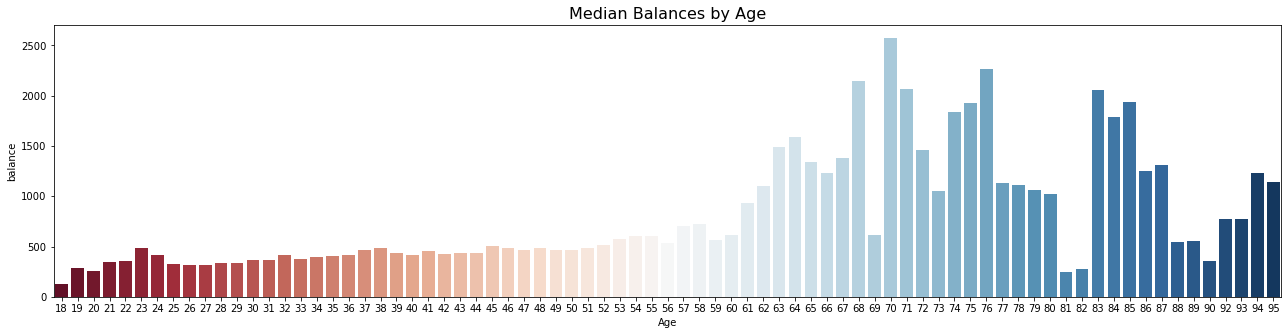

In [181]:
marital_balance = df.groupby(['age'], as_index=False)['balance'].median().sort_values('balance',ascending=False) # job df grouped by median age

fig = plt.figure(figsize=(22,5))

_ = sns.barplot(x="age", y="balance", data=marital_balance,
            label="Total", palette="RdBu")

_ = plt.xlabel('Age')
_ = plt.title('Median Balances by Age', fontsize=16)

## Housing

In [182]:
df.housing.unique()

array(['yes', 'no'], dtype=object)

In [183]:
df.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

## Loan

In [184]:
df.loan.value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

## Contact

In [185]:
df.contact.value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

## Day

In [186]:
len(df.day.unique())

31

In [187]:
df.day.unique()

array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
       29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31])

## Month

In [188]:
len(df.month.unique())

12

In [189]:
df.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

## Duration

In [190]:
len(df.duration.unique())

1573

In [191]:
df.duration.unique()

array([ 261,  151,   76, ..., 1298, 1246, 1556])

From the UCI website: 

this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

We will drop this column since it is highly correlated to term deposit.

In [192]:
del df['duration'] # removing from df

## Campaign

In [193]:
len(df.campaign.unique())

48

In [194]:
df.campaign.unique()

array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12, 13, 19, 14, 24, 16,
       32, 18, 22, 15, 17, 25, 21, 43, 51, 63, 41, 26, 28, 55, 50, 38, 23,
       20, 29, 31, 37, 30, 46, 27, 58, 33, 35, 34, 36, 39, 44])

## Pdays

This is the number of days that passed by after the client was last contacted from a previous campaign.

In [195]:
len(df.pdays.unique())

559

There are too many unique values, so we'll bucket these into categorical values

In [196]:
pdays_df = df.copy() # creating copied df to work with

In [197]:
pdays_df.pdays.min() # min value

-1

In [198]:
pdays_df.pdays.max() # max value

871

In [199]:
import numpy as np
bins = [180, 360, 540, 720, 900]
pdays_df['pdays'] = np.searchsorted(bins, df['pdays'].values)

# pdays are now sorted into bins: 0,1,2,3,4

In [200]:
pdays_df['pdays'].replace({0: 180, 1: 360, 2: 540, 3: 720, 4: 900},inplace=True) # renamed to highest value

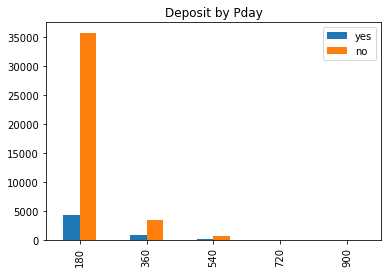

In [201]:
pdays = pd.DataFrame()

pdays['yes'] = pdays_df[pdays_df['deposit'] == 'yes']['pdays'].value_counts()
pdays['no'] = pdays_df[pdays_df['deposit'] == 'no']['pdays'].value_counts()

_ = pdays.plot.bar(title = 'Deposit by Pday')

# the majority of the  pdays are 180 and under

## Previous

In [202]:
len(df.previous.unique())

41

In [203]:
df.previous.unique()

array([  0,   3,   1,   4,   2,  11,  16,   6,   5,  10,  12,   7,  18,
         9,  21,   8,  14,  15,  26,  37,  13,  25,  20,  27,  17,  23,
        38,  29,  24,  51, 275,  22,  19,  30,  58,  28,  32,  40,  55,
        35,  41])

## Poutcome

In [204]:
df.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

## Deposit

In [205]:
df.deposit.unique 

<bound method Series.unique of 0         no
1         no
2         no
3         no
4         no
        ... 
45206    yes
45207    yes
45208    yes
45209     no
45210     no
Name: deposit, Length: 45211, dtype: object>

In [206]:
df['deposit'].value_counts()

no     39922
yes     5289
Name: deposit, dtype: int64

In [207]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


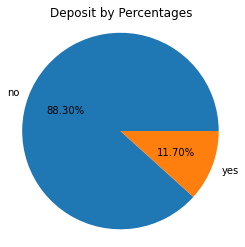

In [208]:
# univariate chart

_ = plt.pie(df['deposit'].value_counts(),labels=['no','yes'],autopct='%1.2f%%')
_ = plt.title('Deposit by Percentages')
_ = plt.axis('square')


In [209]:
df.deposit.value_counts()

no     39922
yes     5289
Name: deposit, dtype: int64

In [210]:
# countplot without percentages

'''
plt.figure(figsize=[12,14])

deposit_categ = ['marital','education','housing','loan','contact','month','poutcome','deposit']
                 
n=1 

for x in deposit_categ:
    plt.subplot(4,2,n)
    sns.countplot(x=x, hue='deposit', edgecolor="black", alpha=0.7, data=df)
    sns.despine()
    plt.title("Count of {} by deposit".format(x))
    n=n+1
plt.tight_layout()
plt.show()

plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='deposit',edgecolor="black", alpha=0.7, data=df)
sns.despine()
plt.title("Count of job by deposit")
plt.show()

'''

'\nplt.figure(figsize=[12,14])\n\ndeposit_categ = [\'marital\',\'education\',\'housing\',\'loan\',\'contact\',\'month\',\'poutcome\',\'deposit\']\n                 \nn=1 \n\nfor x in deposit_categ:\n    plt.subplot(4,2,n)\n    sns.countplot(x=x, hue=\'deposit\', edgecolor="black", alpha=0.7, data=df)\n    sns.despine()\n    plt.title("Count of {} by deposit".format(x))\n    n=n+1\nplt.tight_layout()\nplt.show()\n\nplt.figure(figsize=[14,4])\nsns.countplot(x=\'job\', hue=\'deposit\',edgecolor="black", alpha=0.7, data=df)\nsns.despine()\nplt.title("Count of job by deposit")\nplt.show()\n\n'

<ipython-input-211-be82497f2394>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\


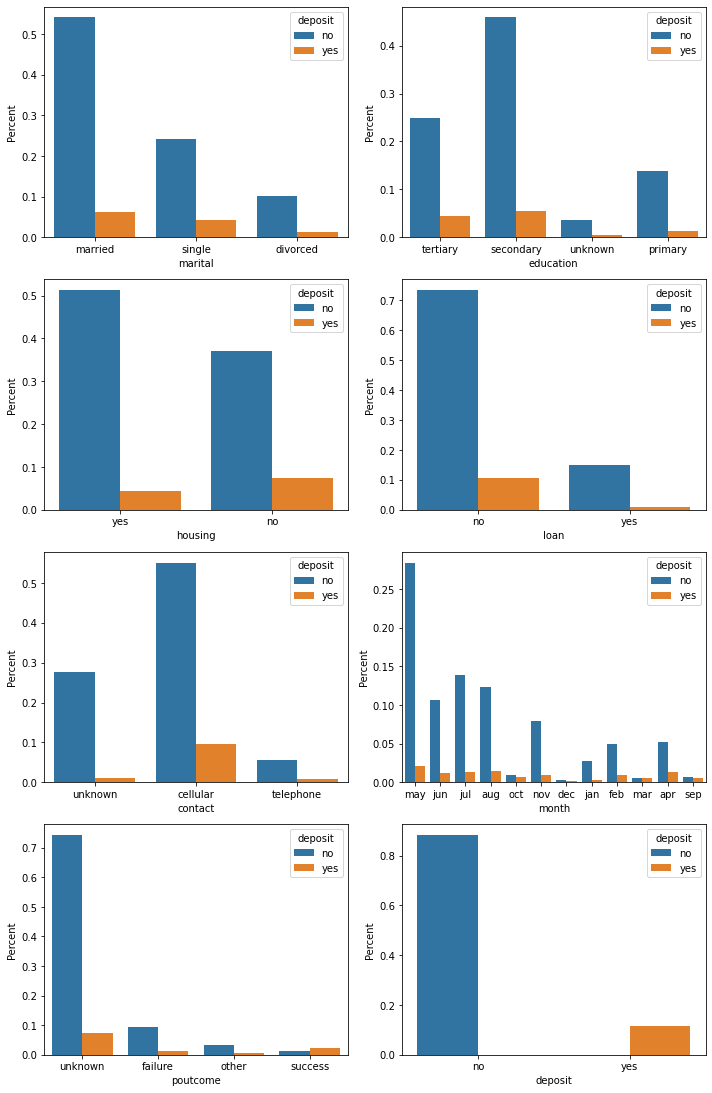

In [211]:
fig = plt.figure(figsize=(10,30))

deposit_categ = df[['marital','education','housing','loan','contact','month','poutcome','deposit']]

for i, col in enumerate(deposit_categ.columns):   
   # PERCENT COLUMN CALCULATION
   deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\
                                   .transform(lambda x: len(x)) / len(deposit_categ)

   plt.subplot(8, 2, i+1)   
   sns.barplot(x=col, y=col+'_pct', hue='deposit', data=deposit_categ)\
          .set(xlabel=col, ylabel='Percent')    

plt.tight_layout()
plt.show()
plt.clf()

plt.close('all')

In [212]:
d = deposit_categ.copy()

indexNames = d[ d['deposit'] == 'no' ].index
# Delete these row indexes from dataFrame
d.drop(indexNames, inplace=True)

<ipython-input-213-05d96f01c165>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\


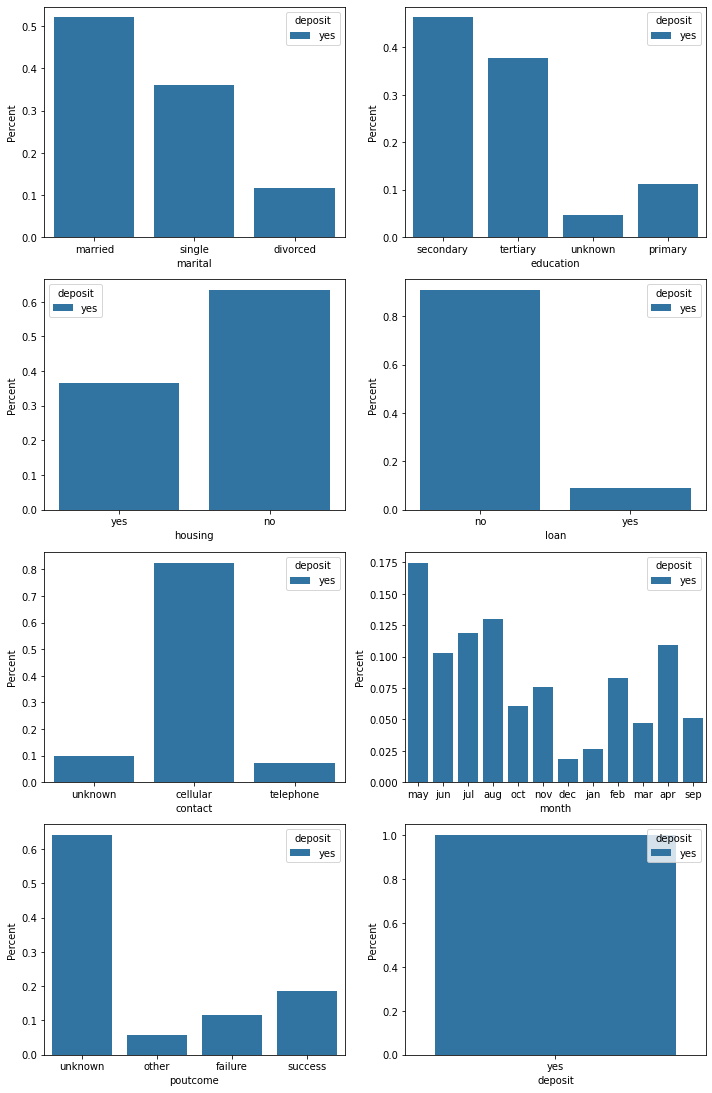

In [213]:
fig = plt.figure(figsize=(10,30))

deposit_categ = d[['marital','education','housing','loan','contact','month','poutcome','deposit']]

for i, col in enumerate(deposit_categ.columns):   
   # PERCENT COLUMN CALCULATION
   deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\
                                   .transform(lambda x: len(x)) / len(deposit_categ)

   plt.subplot(8, 2, i+1)   
   sns.barplot(x=col, y=col+'_pct', hue='deposit', data=deposit_categ)\
          .set(xlabel=col, ylabel='Percent')    

plt.tight_layout()
plt.show()
plt.clf()

plt.close('all')

<ipython-input-214-003b82f45cf2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\


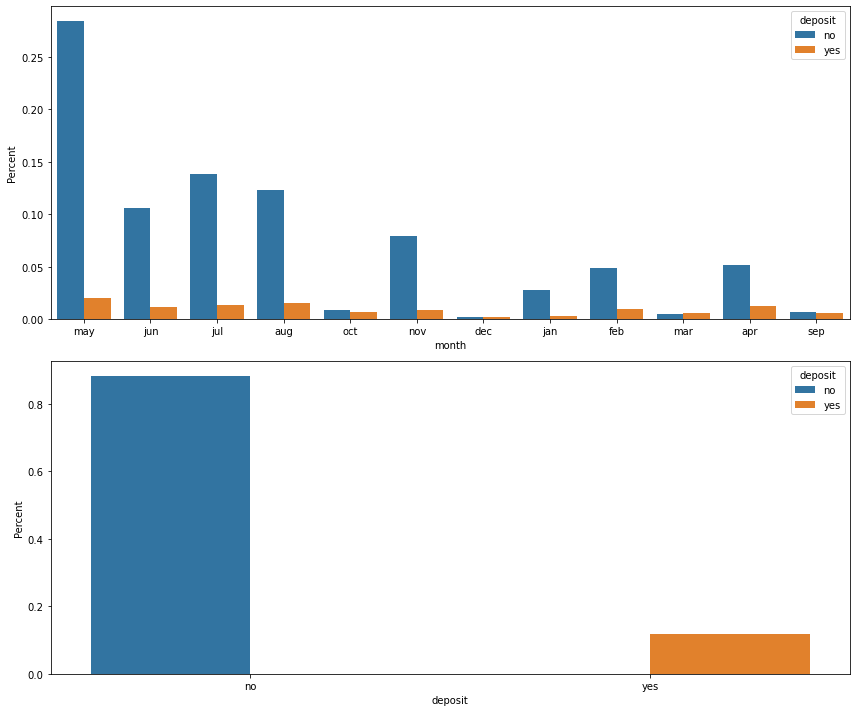

In [214]:
fig = plt.figure(figsize=(12,10))

deposit_categ = df[['month','deposit']]

for i, col in enumerate(deposit_categ.columns):   
   # percent col calculation
   deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\
                                   .transform(lambda x: len(x)) / len(deposit_categ)

   plt.subplot(2, 1, i+1)   
   sns.barplot(x=col, y=col+'_pct', hue='deposit', data=deposit_categ)\
          .set(xlabel=col, ylabel='Percent')    

plt.tight_layout()
plt.show()
plt.clf()

plt.close('all')

In [215]:
d = deposit_categ.copy()

indexNames = d[ d['deposit'] == 'no' ].index
# Delete these row indexes from dataFrame
d.drop(indexNames, inplace=True)

<ipython-input-216-44e54821a694>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\


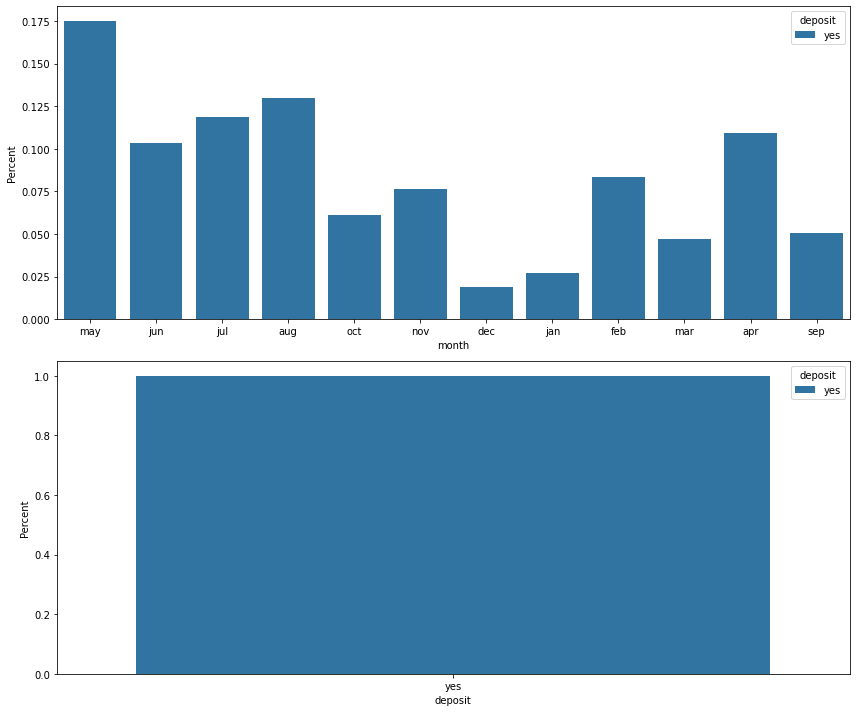

In [216]:
fig = plt.figure(figsize=(12,10))

deposit_categ = d[['month','deposit']]

for i, col in enumerate(deposit_categ.columns):   
   # percent col calculation
   deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\
                                   .transform(lambda x: len(x)) / len(deposit_categ)

   plt.subplot(2, 1, i+1)   
   sns.barplot(x=col, y=col+'_pct', hue='deposit', data=deposit_categ)\
          .set(xlabel=col, ylabel='Percent')    

plt.tight_layout()
plt.show()
plt.clf()

plt.close('all')

<ipython-input-217-a2de296aa4b5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\


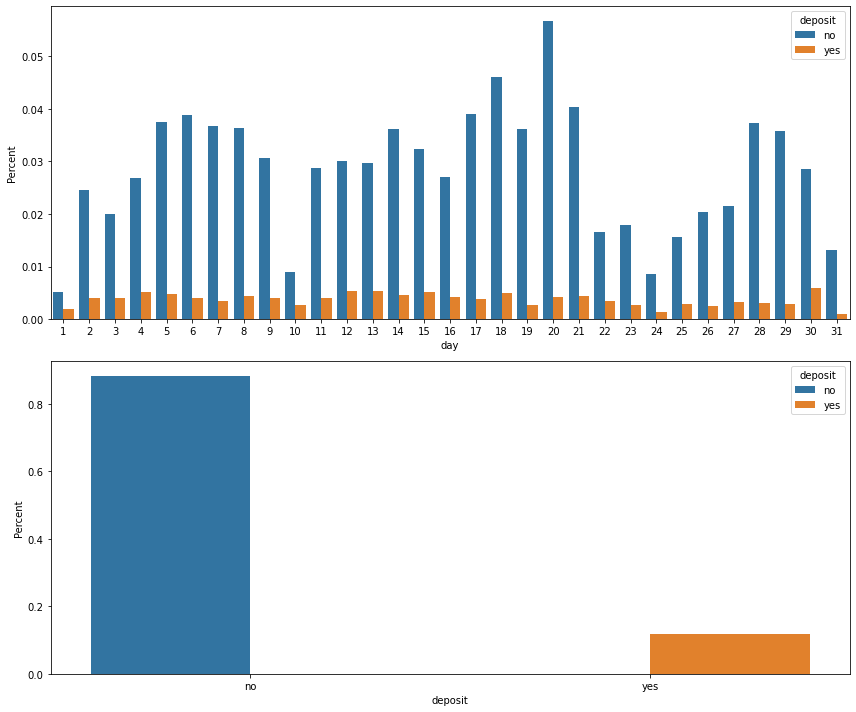

In [217]:
fig = plt.figure(figsize=(12,10))

deposit_categ = df[['day','deposit']]

for i, col in enumerate(deposit_categ.columns):   
   # percent col calculation
   deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\
                                   .transform(lambda x: len(x)) / len(deposit_categ)

   plt.subplot(2, 1, i+1)   
   sns.barplot(x=col, y=col+'_pct', hue='deposit', data=deposit_categ)\
          .set(xlabel=col, ylabel='Percent')    

plt.tight_layout()
plt.show()
plt.clf()

plt.close('all')

In [218]:
d = deposit_categ.copy()

indexNames = d[ d['deposit'] == 'no' ].index
# Delete these row indexes from dataFrame
d.drop(indexNames, inplace=True)

<ipython-input-219-9bc25249da1c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\


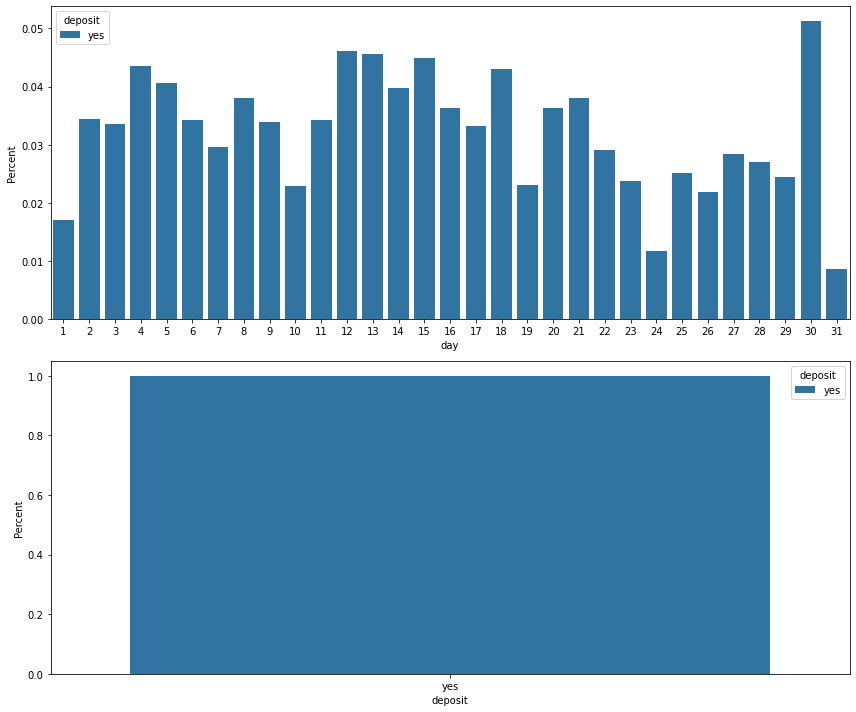

In [219]:
fig = plt.figure(figsize=(12,10))

deposit_categ = d[['day','deposit']]

for i, col in enumerate(deposit_categ.columns):   
   # percent col calculation
   deposit_categ[col+'_pct'] = deposit_categ.groupby(['deposit', col])[col]\
                                   .transform(lambda x: len(x)) / len(deposit_categ)

   plt.subplot(2, 1, i+1)   
   sns.barplot(x=col, y=col+'_pct', hue='deposit', data=deposit_categ)\
          .set(xlabel=col, ylabel='Percent')    

plt.tight_layout()
plt.show()
plt.clf()

plt.close('all')

## Categorical - Continuous Data

In [220]:
categ_cont_df = df[['default','housing','loan','deposit']]

In [221]:
categ_cont_df['default'] = categ_cont_df['default'].map({'yes': '1', 'no': '0'})
categ_cont_df['housing'] = categ_cont_df['housing'].map({'yes': '1', 'no': '0'})
categ_cont_df['loan'] = categ_cont_df['loan'].map({'yes': '1', 'no': '0'})
categ_cont_df['deposit'] = categ_cont_df['deposit'].map({'yes': '1', 'no': '0'})

<ipython-input-221-7e6cf1f554b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_cont_df['default'] = categ_cont_df['default'].map({'yes': '1', 'no': '0'})
<ipython-input-221-7e6cf1f554b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_cont_df['housing'] = categ_cont_df['housing'].map({'yes': '1', 'no': '0'})
<ipython-input-221-7e6cf1f554b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [222]:
# converting to integer

categ_cont_df['default'] = categ_cont_df['default'].astype(int)
categ_cont_df['loan'] = categ_cont_df['loan'].astype(int)
categ_cont_df['housing'] = categ_cont_df['housing'].astype(int)
categ_cont_df['deposit'] = categ_cont_df['deposit'].astype(int)

<ipython-input-222-61f9d72f660e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_cont_df['default'] = categ_cont_df['default'].astype(int)
<ipython-input-222-61f9d72f660e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categ_cont_df['loan'] = categ_cont_df['loan'].astype(int)
<ipython-input-222-61f9d72f660e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [223]:
# point-biseral

for x, y in categ_cont_df.iteritems():
    pointbi = stats.pointbiserialr(categ_cont_df.default,y)   
    print(pointbi, x)

PointbiserialrResult(correlation=0.9999999999999963, pvalue=0.0) default
PointbiserialrResult(correlation=-0.006025218356252599, pvalue=0.20015465917581932) housing
PointbiserialrResult(correlation=0.07723424107915192, pvalue=8.909521427986304e-61) loan
PointbiserialrResult(correlation=-0.022418965890751284, pvalue=1.8663265262329448e-06) deposit


In [224]:
categ_cont_corr = categ_cont_df.corr()
categ_cont_corr

,default,housing,loan,deposit
default,1.000000,-0.006025,0.077234,-0.022419
housing,-0.006025,1.000000,0.041323,-0.139173
loan,0.077234,0.041323,1.000000,-0.068185
deposit,-0.022419,-0.139173,-0.068185,1.000000


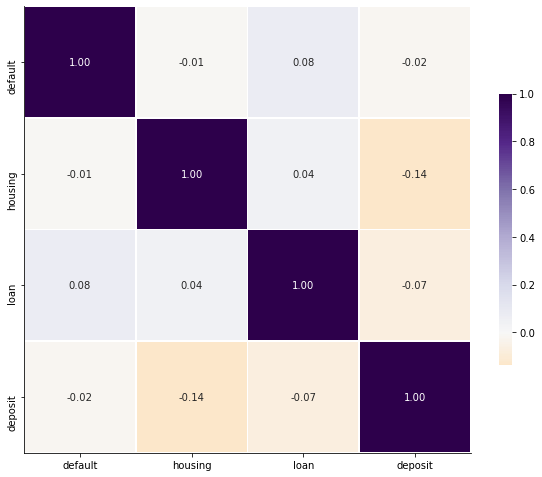

In [225]:
ax = sns.heatmap(categ_cont_corr,  vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
sns.despine()
ax.figure.set_size_inches(10,10)
 
bottom, top = ax.get_ylim()

plt.show()

In [226]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


## Continuous Data

In [227]:
df['deposit'] = LabelEncoder().fit_transform(df['deposit']) # transforming categorical values to integers

In [228]:
continuous_df = pd.DataFrame(df, columns=['deposit','age','balance','day','campaign','pdays','previous'])
continuous_df_corr = continuous_df.corr()

In [229]:
continuous_df_corr # getting correlations

,deposit,age,balance,day,campaign,pdays,previous
deposit,1.000000,0.025155,0.052838,-0.028348,-0.073172,0.103621,0.093236
age,0.025155,1.000000,0.097783,-0.009120,0.004760,-0.023758,0.001288
balance,0.052838,0.097783,1.000000,0.004503,-0.014578,0.003435,0.016674
day,-0.028348,-0.009120,0.004503,1.000000,0.162490,-0.093044,-0.051710
campaign,-0.073172,0.004760,-0.014578,0.162490,1.000000,-0.088628,-0.032855
pdays,0.103621,-0.023758,0.003435,-0.093044,-0.088628,1.000000,0.454820
previous,0.093236,0.001288,0.016674,-0.051710,-0.032855,0.454820,1.000000


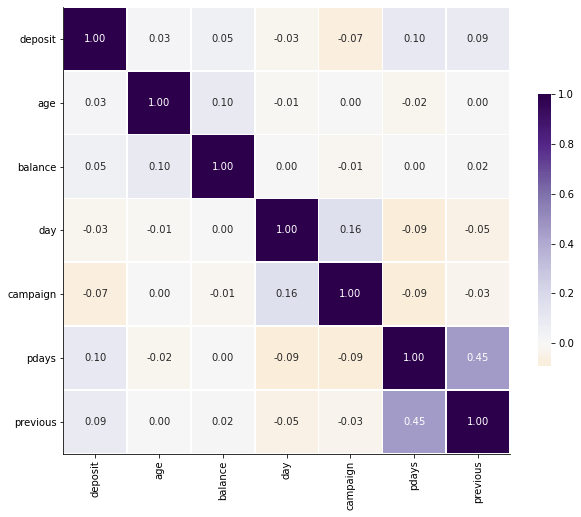

In [230]:
ax = sns.heatmap(continuous_df_corr,  vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
sns.despine()
ax.figure.set_size_inches(10,10)

plt.show()

In [231]:
df_clean = df.copy()

In [232]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,0


In [233]:
# Y/N data transformation

df_clean['default'] = df_clean['default'].map({'yes': '1', 'no': '0'})
df_clean['housing'] = df_clean['housing'].map({'yes': '1', 'no': '0'})
df_clean['loan'] = df_clean['loan'].map({'yes': '1', 'no': '0'})

In [234]:
df_clean['job'] = df_clean['job'].map({'management': '0', 'technician': '1', 'entrepreneur': '2', 'blue-collar': '3','unknown': '4', 'retired': '5', 'admin': '6', 'admin.': '7','services': '8','self-employed': '9', 'unemployed': '10', 'housemaid': '11', 'student': '12'})
df_clean['marital'] = df_clean['marital'].map({'married': '0', 'single': '1', 'divorced': '2'})
df_clean['education'] = df_clean['education'].map({'primary': '0', 'secondary': '1','tertiary': '2', 'unknown': '3'})
df_clean['contact'] = df_clean['contact'].map({'unknown': '0', 'cellular': '1', 'telephone': '2'})
df_clean['month'] = df_clean['month'].map({'jan': '0', 'feb': '1','mar': '2', 'apr': '3','may': '4', 'jun': '5','jul': '6', 'aug': '7','sep': '8', 'oct': '9','nov': '10', 'dec': '11'})
df_clean['poutcome'] = df_clean['poutcome'].map({'unknown': '0', 'failure': '1', 'other': '2','success': '3'})

In [235]:
df_clean['job'] = df_clean['job'].astype(int)
df_clean['marital'] = df_clean['marital'].astype(int)
df_clean['education'] = df_clean['education'].astype(int)
df_clean['contact'] = df_clean['contact'].astype(int)
df_clean['month'] = df_clean['month'].astype(int)
df_clean['poutcome'] = df_clean['poutcome'].astype(int)
df_clean['housing'] = df_clean['housing'].astype(int)
df_clean['default'] = df_clean['default'].astype(int)
df_clean['loan'] = df_clean['loan'].astype(int)

In [236]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45211 non-null  int64
 1   job        45211 non-null  int64
 2   marital    45211 non-null  int64
 3   education  45211 non-null  int64
 4   default    45211 non-null  int64
 5   balance    45211 non-null  int64
 6   housing    45211 non-null  int64
 7   loan       45211 non-null  int64
 8   contact    45211 non-null  int64
 9   day        45211 non-null  int64
 10  month      45211 non-null  int64
 11  campaign   45211 non-null  int64
 12  pdays      45211 non-null  int64
 13  previous   45211 non-null  int64
 14  poutcome   45211 non-null  int64
 15  deposit    45211 non-null  int64
dtypes: int64(16)
memory usage: 5.5 MB


In [237]:
 #convert categorical columns to dummies
#cat_columns = ['job', 'marital', 'education', 'contact', 'poutcome']

In [238]:
# create dummy variables for categorical cols
'''
for col in  cat_columns:
    df_clean = pd.concat([df_clean.drop(col, axis=1), pd.get_dummies(df_clean[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
    
'''

"\nfor col in  cat_columns:\n    df_clean = pd.concat([df_clean.drop(col, axis=1), pd.get_dummies(df_clean[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)\n    \n"

In [239]:
# drop irrelevant cols

#df_clean.drop([
        #'campaign',
        #'pdays',
        #'previous',
        #'month'], axis=1,inplace=True)

In [240]:
X = df_clean.drop(columns = 'deposit')
y = df_clean[['deposit']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

### Feature Selection

In [241]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [242]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.324072
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.102     
Dependent Variable: deposit          AIC:              29333.2352
Date:               2020-09-19 16:33 BIC:              29464.0216
No. Observations:   45211            Log-Likelihood:   -14652.   
Df Model:           14               LL-Null:          -16315.   
Df Residuals:       45196            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
age          -0.0248    0.0011  -23.5037  0.0000  -0.0269  -0.0227
job          -0.0214    0.0041   -5.1934  0.0000  -0.0295  -0.

We'll remove the variables with p-values above .05 since they're not statistically significant

In [243]:
df_clean.drop([
        'marital',
        'education',
        'default',
        'previous'], axis=1,inplace=True)

In [244]:
X = df_clean.drop(columns = 'deposit')
y = df_clean[['deposit']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

### XGBoost

In [245]:
#train XGBoost

xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.914: test: 0.890


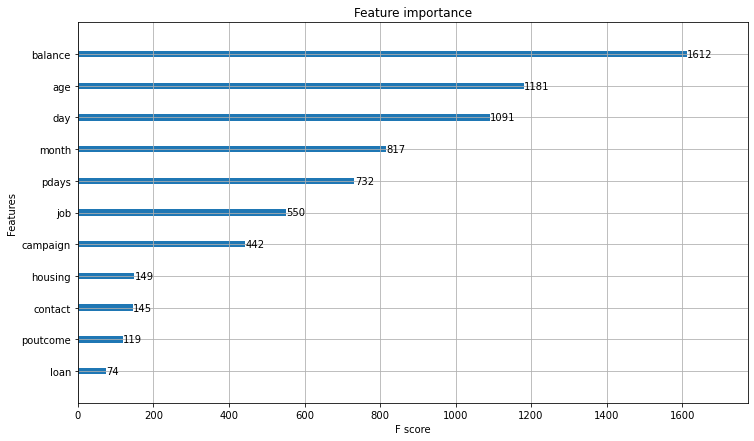

In [246]:
fig, ax = plt.subplots(figsize=(12, 7))

plot_importance(xgb, ax=ax)
plt.show()

### Logistic Regression

In [94]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.324306
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.101     
Dependent Variable: deposit          AIC:              29346.3824
Date:               2020-09-19 14:44 BIC:              29442.2924
No. Observations:   45211            Log-Likelihood:   -14662.   
Df Model:           10               LL-Null:          -16315.   
Df Residuals:       45200            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
age          -0.0255    0.0010  -24.6862  0.0000  -0.0275  -0.0234
job          -0.0188    0.0040   -4.6571  0.0000  -0.0268  -0.

In [95]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [119]:
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,scoring='roc_auc')
logreg_cv.fit(X_train,y_train)

print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.p

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

tuned hyperparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.6711551949715446


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

In [419]:
logreg=LogisticRegression(C=10,penalty="l2")
logreg.fit(X_train,y_train)
#print("score",logreg.score(X_test,y_test)) # accuracy of classifier on test set

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [121]:
y_pred = logreg.predict(X_test) # don't use this on report - use roc/auc
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


### ROC Curve

In [420]:
# ROC Curve: Plot of False Positive Rate (x) vs. True Positive Rate (y)
'''

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()'''

'\nfrom sklearn.metrics import roc_auc_score\nfrom sklearn.metrics import roc_curve\nlogit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))\nfpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])\nplt.figure()\nplt.plot(fpr, tpr, label=\'Logistic Regression (area = %0.2f)\' % logit_roc_auc)\nplt.plot([0, 1], [0, 1],\'r--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Receiver operating characteristic\')\nplt.legend(loc="lower right")\nplt.savefig(\'Log_ROC\')\nplt.show()'

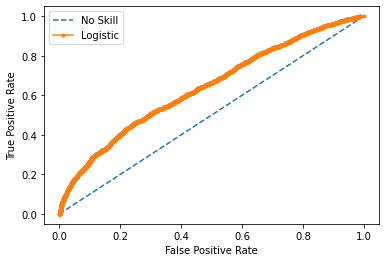

In [102]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


yhat = logreg.predict_proba(X_test)

pos_probs = yhat[:, 1]

pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

fpr, tpr, _ = roc_curve(y_test, pos_probs)

pyplot.plot(fpr, tpr, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

### AUC Curve

In [103]:
# the auc gives a single score for a classifier model across all threshold values.
roc_auc = roc_auc_score(y_test, pos_probs)

In [104]:
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
pos_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(y_test, pos_probs)
print('No Skill ROC AUC %.3f' % roc_auc)
# skilled model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
pos_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(y_test, pos_probs)
print('Logistic ROC AUC %.3f' % roc_auc)

No Skill ROC AUC 0.489
Logistic ROC AUC 0.668


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [105]:
# example of a precision-recall curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

In [106]:
# calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)

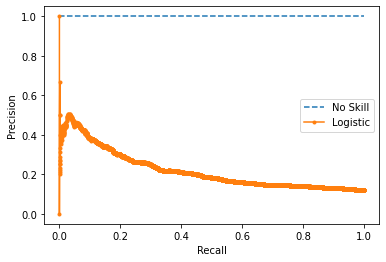

In [107]:
# predict probabilities
yhat = logreg.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Confusion Matrix

In [124]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[11884    44]
 [ 1542    94]]


Based on the confusion matrix above, we have 11884 + 44 correct predictions and 1542 + 94 incorrect predictions

### Classification Report

In [123]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     11928
           1       0.68      0.06      0.11      1636

    accuracy                           0.88     13564
   macro avg       0.78      0.53      0.52     13564
weighted avg       0.86      0.88      0.84     13564



## Random Forest

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [126]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)

In [127]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [128]:
from sklearn.model_selection import GridSearchCV # takes a long time to run

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring='roc_auc')
CV_rfc.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring='roc_auc')

In [129]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [130]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [131]:
rfc1.fit(X_train, y_train)

<ipython-input-131-af5299cc6513>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc1.fit(X_train, y_train)


RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [132]:
pred=rfc1.predict(X_test)

In [421]:
#print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

In [137]:
y_pred = rfc1.predict(X_test) # don't use this on report - use roc/auc
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(rfc1.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.89


### Classification Report

In [135]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11928
           1       0.71      0.17      0.28      1636

    accuracy                           0.89     13564
   macro avg       0.80      0.58      0.61     13564
weighted avg       0.87      0.89      0.86     13564



### ROC Curve

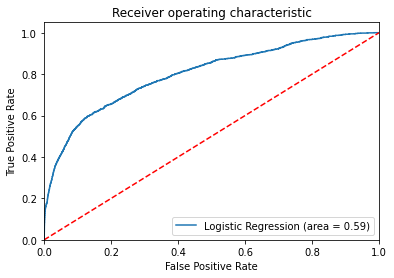

In [423]:
# Plot of False Positive Rate (x) vs. True Positive Rate (y)

logit_roc_auc = roc_auc_score(y_test, rfc1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [424]:
# auc curve

# the auc gives a single score for a classifier model across all threshold values.
roc_auc = roc_auc_score(y_test, pos_probs)
print(roc_auc)

0.7759003371368883


In [139]:
rfm = RandomForestClassifier()
n_estimators = np.arange(50, 400, 50)
max_depth = np.arange(1,8)
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depth}

rf_cv = GridSearchCV(rfm, param_grid, cv=5, scoring='roc_auc')

In [144]:
rf_cv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
             scoring='roc_auc')

In [145]:
print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_)) 
print("Best score is {}".format(rf_cv.best_score_))

Tuned Random Forest Parameters: {'max_depth': 7, 'n_estimators': 350}
Best score is 0.7784296087744315


In [262]:
rfm = RandomForestClassifier(max_depth=7, n_estimators=350)

rfm.fit(X_train, y_train)

<ipython-input-262-f38e9d64240a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfm.fit(X_train, y_train)


RandomForestClassifier(max_depth=7, n_estimators=350)

In [263]:
print('ROC AUC score:', roc_auc_score(y_test, rfm.predict_proba(X_test)[:,1]))

ROC AUC score: 0.7759003371368883


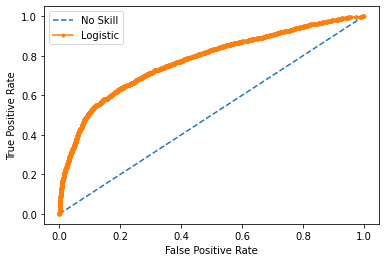

In [267]:
# roc curve

# predict probabilities
yhat = rfm.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [268]:
# auc curve

# the auc gives a single score for a classifier model across all threshold values.
roc_auc = roc_auc_score(y_test, pos_probs)

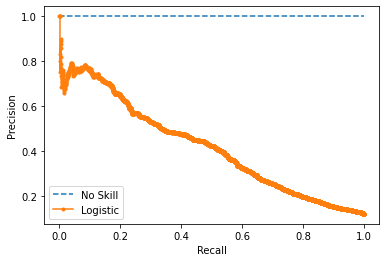

In [270]:

yhat = rfm.predict_proba(X_test)
pos_probs = yhat[:, 1]
no_skill = len(y[y==1]) / len(y)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
pyplot.plot(recall, precision, marker='.', label='Logistic')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()

pyplot.show()

In [445]:
pred=rfm.predict(X_test)

In [446]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred)
print(confusion_matrix)

[[11686   237]
 [ 1259   382]]


In [259]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11923
           1       0.72      0.18      0.29      1641

    accuracy                           0.89     13564
   macro avg       0.81      0.58      0.61     13564
weighted avg       0.88      0.89      0.86     13564



In [260]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.8923621350634031


In [425]:
#y_pred = rfm.predict(X_test) # don't use this on report - use roc/auc
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(rfc1.score(X_test, y_test)))

### Thresholding

In [307]:
y_pred = (rfm.predict_proba(X_test)[:,1] >= 0.38).astype(bool)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     11923
           1       0.49      0.35      0.41      1641

    accuracy                           0.88     13564
   macro avg       0.70      0.65      0.67     13564
weighted avg       0.86      0.88      0.87     13564



In [310]:
fpr, tpr, thresholds = roc_curve(y_test, yhat)

J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.153213


In [365]:
y_pred = (rfm.predict_proba(X_test)[:,1] >= 0.15).astype(bool)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87     11923
           1       0.31      0.64      0.42      1641

    accuracy                           0.79     13564
   macro avg       0.63      0.72      0.64     13564
weighted avg       0.87      0.79      0.81     13564



In [428]:
def adjust_pred_prob(y_pred_prob, new_threshold):
    
    return [1 if y >= new_threshold else 0 for y in y_pred_prob]

In [429]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, pred)

0.5845780279237437

In [430]:
thresholds=np.arange(0,1,.01)

In [431]:
accuracy_points = []

for t in thresholds:
        adjusted_y_pred = adjust_pred_prob(yhat, new_threshold=t)
        new_balance = accuracy_score(y_test, adjusted_y_pred)
        accuracy_points.append(new_balance)

In [432]:
balanced_accuracy_points = []

for t in thresholds:
        adjusted_y_pred = adjust_pred_prob(yhat, new_threshold=t)
        new_balance = balanced_accuracy_score(y_test, adjusted_y_pred)
        balanced_accuracy_points.append(new_balance)

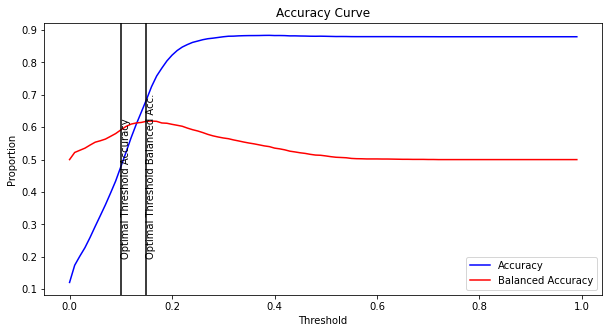

In [453]:
plt.figure(figsize=(10,5))
plt.plot(thresholds, accuracy_points, color='blue')
plt.plot(thresholds, balanced_accuracy_points, color='red')
plt.title('Accuracy Curve')
plt.legend(('Accuracy', 'Balanced Accuracy'))
plt.xlabel('Threshold')
plt.axvline(x=.1, color='black')
plt.text(.1,.2,'Optimal Threshold Accuracy',rotation=90)
plt.axvline(x=.15, color='black')
plt.text(.15,.2,'Optimal Threshold Balanced Acc.',rotation=90)
plt.ylabel('Proportion')
plt.show()

In [379]:
precision, recall, thresholds = precision_recall_curve(y_test, yhat)
thresholds = np.append(thresholds, 1)

In [380]:
# Calculate F1 Score Curve
f1_points = []

for t in thresholds:
        adjusted_y_pred = adjust_pred_prob(yhat, new_threshold=t)
        new_f1 = metrics.f1_score(y_test, adjusted_y_pred)
        f1_points.append(new_f1)

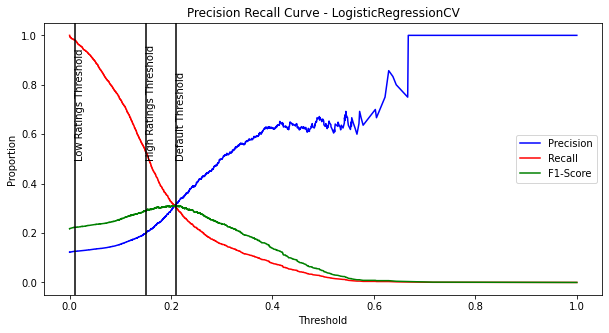

In [400]:
# Plot Balanced Accuracy, Accuracy, Precision, Recall and F1 Score on a graph together.

plt.figure(figsize=(10,5))
plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='red')
plt.plot(thresholds, f1_points, color='green')
plt.title('Precision Recall Curve - LogisticRegressionCV')
plt.legend(('Precision', 'Recall', 'F1-Score'))
plt.xlabel('Threshold')
plt.ylabel('Proportion')
plt.axvline(x=.01, color='black')
plt.text(.01,.50,'Low Ratings Threshold',rotation=90)
plt.axvline(x=.15, color='black')
plt.text(.15,.50,'High Ratings Threshold',rotation=90)
plt.axvline(x=.21, color='black')
plt.text(.21,.50,'Default Threshold',rotation=90)
plt.show()

In [454]:
# logistic regression

from numpy import arange
from numpy import argmax
from sklearn.metrics import f1_score

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
probs = yhat[:, 1]
thresholds = arange(0, 1, 0.001)
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]

ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Threshold=0.208, F-Score=0.31162


In [294]:
# random forest

from numpy import arange
from numpy import argmax
from sklearn.metrics import f1_score

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

rfm = RandomForestClassifier()
rfm.fit(X_train, y_train)

yhat = rfm.predict_proba(X_test)
probs = yhat[:, 1]
thresholds = arange(0, 1, 0.001)
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

<ipython-input-294-c374045543f9>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfm.fit(X_train, y_train)


Threshold=0.271, F-Score=0.45797
